In [6]:
import sympy as sp

# Using operator and kets from quantum module to represent differential operators and pdfs
from  sympy.physics.quantum import Ket as Func
from  sympy.physics.quantum import Operator
# Disable Ket notation |f> for functions
Func.lbracket_latex =''
Func.rbracket_latex = ''

sp.init_printing()

# Chapman Enskog analysis

Particle distribution function $f$:

In [7]:
c = sp.Symbol("c_x")
dt = sp.Symbol("Delta_t")
t = sp.symbols("t")
f = Func("f")
C = Func("C")

Differential operators (defined simply as non-commutative symbols here)

In [8]:
Dx = Operator("\partial_x") 
Dt = Operator("\partial_t")

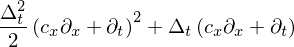

In [9]:
taylorOrder = 2
taylorOperator = sum(dt**k * (Dt + c* Dx)**k / sp.functions.factorial(k)
                     for k in range(1, taylorOrder+1))
taylorOperator

As right-hand-side we use the abstract collision operator $C$, which corresponds to (4.5)

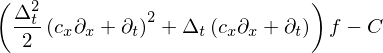

In [10]:
eq_4_5 = (taylorOperator * f) - C
eq_4_5

Following the same steps as in the book, getting rid of second derivative, and discarding $\Delta_t^3$ we get to (4.7)

In [ ]:
eq_4_7 = eq_4_5 - (dt/2)* (Dt + c*Dx) * eq_4_5
eq_4_7 = eq_4_7.expand().subs(dt**3, 0)
eq_4_7

### Chapman Enskog Ansatz

Open Question:
 why is not everything expanded equally (derivatives start at 1, spatial terminates one earlier...)

In [ ]:
eps = sp.Symbol("epsilon")

ceSymbolsF = [Func("f{}".format(i)) for i in range(3)]
ceSymbolsDt = [Operator("\partial_t^{{ ({}) }}".format(i)) for i in range(1,3)]
ceSymbolsDx = [Operator("\partial_x^{{ ({}) }}".format(i)) for i in range(1,2)]

ceF =  sum(eps**k * s for k, s in enumerate(ceSymbolsF, start=0))
ceDt = sum(eps**k * s for k, s in enumerate(ceSymbolsDt, start=1))
ceDx = sum(eps**k * s for k, s in enumerate(ceSymbolsDx, start=1))

ceSubstitutions = {
    Dt : ceDt,
    Dx : ceDx,
    f: ceF
}
ceSubstitutions

Inserting the SRT/BGK collision operator

In [ ]:
srtC = -dt / sp.Symbol("tau") * ( ceF - ceSymbolsF[0])
srtC

In [ ]:
eq_4_7_ce = eq_4_7.subs(ceSubstitutions).subs(C, srtC).expand().collect(eps)
eq_4_7_ce

In [ ]:
eq_4_9_a = (eq_4_7_ce.coeff(eps) / dt).expand()
eq_4_9_a

In [ ]:
eq_4_9_b = (eq_4_7_ce.coeff(eps**2) / dt).expand()
eq_4_9_b

Computing moments

In [ ]:
import operator
from functools import reduce
def prod(factors):
    return reduce(operator.mul, factors, 1)

def getMomentSymbol(idx, order):
    momentOrderStr = ['alpha', 'beta', 'gamma', 'delta']
    momentOrderStr = "_".join(momentOrderStr[:order-1] + ['x'])
    return sp.Symbol("Pi^(%d)_%s" % (idx, momentOrderStr), commutative=False)

def takeMoments(eqn, order):
    markerTerms = sp.symbols("c_alpha c_beta c_gamma c_delta")
    velocityTermSet = set(markerTerms)
    velocityTermSet.add(c)
    factor = prod(markerTerms[:order])
    eqn = (eqn*factor).expand()
    result = 0
    for fac in eqn.args:
        occuringFs = list(fac.atoms(Func))
        assert len(occuringFs) < 2
        if len(occuringFs) == 0:
            result += fac
            continue
        fIdx = ceSymbolsF.index(occuringFs[0])
        
        occuringCs = fac.atoms(sp.Symbol).intersection(velocityTermSet)
        facWithoutCs = sp.cancel(fac / prod(occuringCs) / occuringFs[0])
        assert not facWithoutCs.atoms(sp.Symbol).intersection(velocityTermSet), "Non-linear velocity term"
        
        # TODO handle multiple non-marker terms
        moment = getMomentSymbol(fIdx, len(occuringCs))
        #momentOrderStr = ['alpha', 'beta', 'gamma', 'delta']
        #momentOrderStr = "_".join(momentOrderStr[:len(occuringCs)])
        #moment = sp.Symbol("Pi^(%d)_%s" % (fIdx, momentOrderStr), commutative=False)
        result += facWithoutCs * moment
        
    return result

In [ ]:
rho = Func("rho")
u_x = Func("u_x")
momentReplacements = {
    getMomentSymbol(0, 0): rho,
    getMomentSymbol(0, 1): rho * u_x,
    
    getMomentSymbol(1, 0): 0, # According to eq 4.4
    getMomentSymbol(1, 1): 0,
    getMomentSymbol(2, 0): 0,
    getMomentSymbol(2, 1): 0,
}
momentReplacements

### Moments

Moments of $\epsilon$-sorted equations

$O(\epsilon)$

In [ ]:
eq_4_10_a = takeMoments(eq_4_9_a, 0).subs(momentReplacements)
eq_4_10_a

In [ ]:
eq_4_10_b = takeMoments(eq_4_9_a, 1).subs(momentReplacements)
eq_4_10_b

In [ ]:
eq_4_10_c = takeMoments(eq_4_9_a, 2).subs(momentReplacements)
eq_4_10_c

$O(\epsilon^2)$

In [ ]:
eq_4_12_a = takeMoments(eq_4_9_b, 0).subs(momentReplacements)
eq_4_12_a

In [ ]:
eq_4_12_b = takeMoments(eq_4_9_b, 1).subs(momentReplacements)
eq_4_12_b

Recombination

In [ ]:
(eps * eq_4_10_a + eps**2 * eq_4_12_a).expand()

In [ ]:
(eps * eq_4_10_b + eps**2 * eq_4_12_b).expand()

In [ ]:
stressTensorSubs = -

In [ ]:
from lbmpy.maxwellian_equilibrium import getMomentsOfDiscreteMaxwellianEquilibrium
from lbmpy.stencils import getStencil
from lbmpy.moments import momentsOfOrder
stencil = getStencil("D3Q19")
dim = len(stencil[0])
moments = tuple(momentsOfOrder(2, dim=dim))
print(moments)
u = Func("u_x"), Func("u_y"), Func("u_z")
rho = Func("rho")
pi_ab = getMomentsOfDiscreteMaxwellianEquilibrium(stencil, moments,c_s_sq=sp.Rational(1,3), order=2, u=u, rho=rho)
pi_ab

In [ ]:
from lbmpy.maxwellian_equilibrium import getMomentsOfContinuousMaxwellianEquilibrium
pi_ab2 = getMomentsOfContinuousMaxwellianEquilibrium(moments, dim, c_s_sq=sp.Rational(1,3), order=2)
pi_ab2

In [ ]:
sp.solve(eq_4_10_c, getMomentSymbol(1, 2))[0]

In [ ]:
from lbmpy.chapman_enskog import *
productRule((ceSymbolsDt[0] * pi_ab[1]).expand())

In [ ]:
dtSubsDict = {
    ceSymbolsDt[0] * rho: -ceSymbolsDx[0]*(rho*u[0]),
    productRule((ceSymbolsDt[0] * (rho * u[1])).expand()) : sp.Symbol("bla")
}
dtSubsDict

In [ ]:
-ceSymbolsDx[0]*(rho*u[0])